21:08:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:01 - cmdstanpy - INFO - Chain [1] done processing


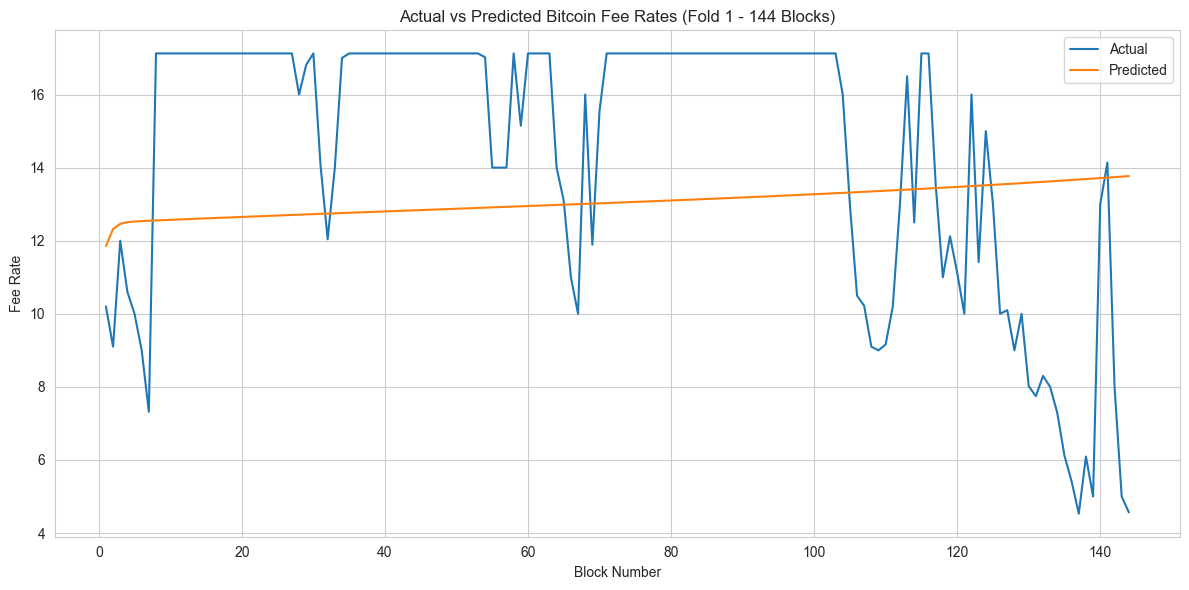

21:09:05 - cmdstanpy - INFO - Chain [1] start processing
21:09:06 - cmdstanpy - INFO - Chain [1] done processing


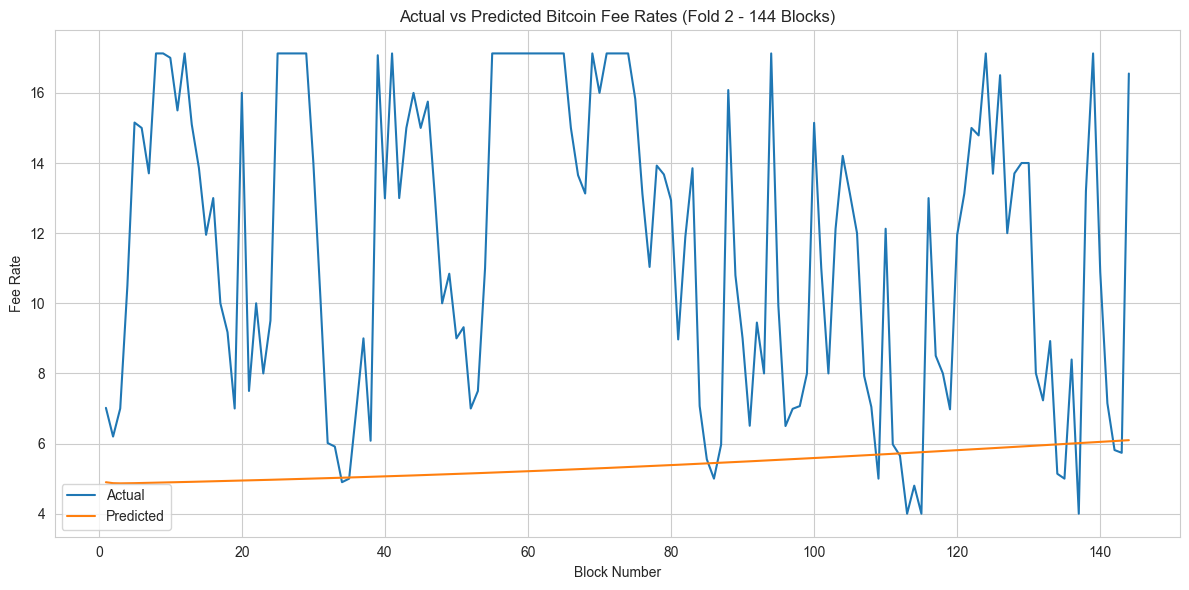

21:09:09 - cmdstanpy - INFO - Chain [1] start processing
21:09:11 - cmdstanpy - INFO - Chain [1] done processing


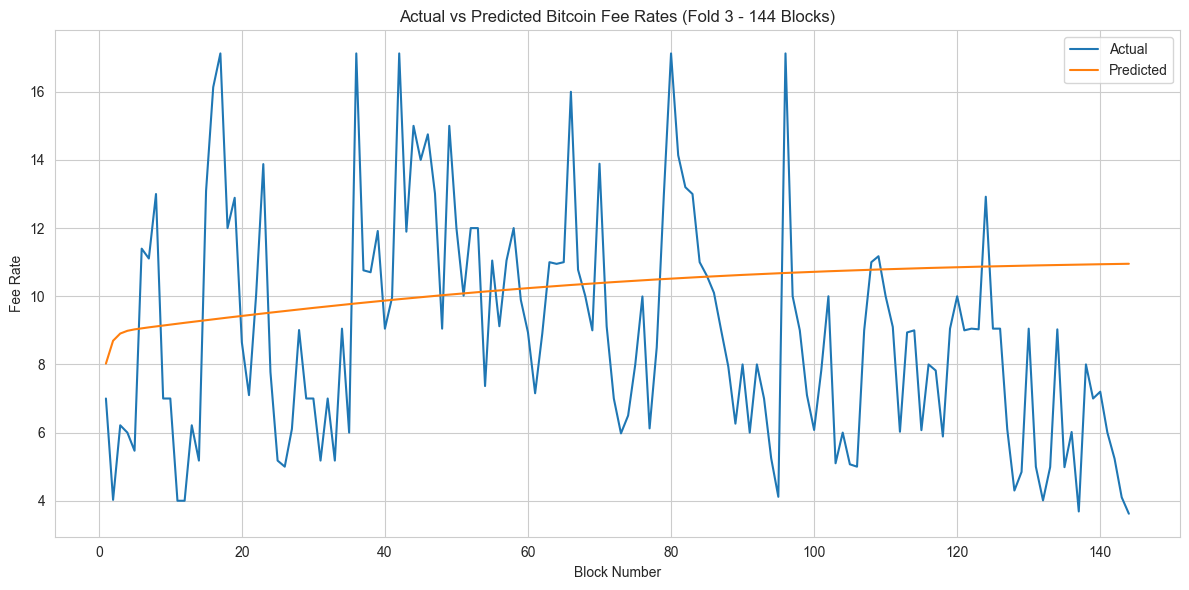

21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing


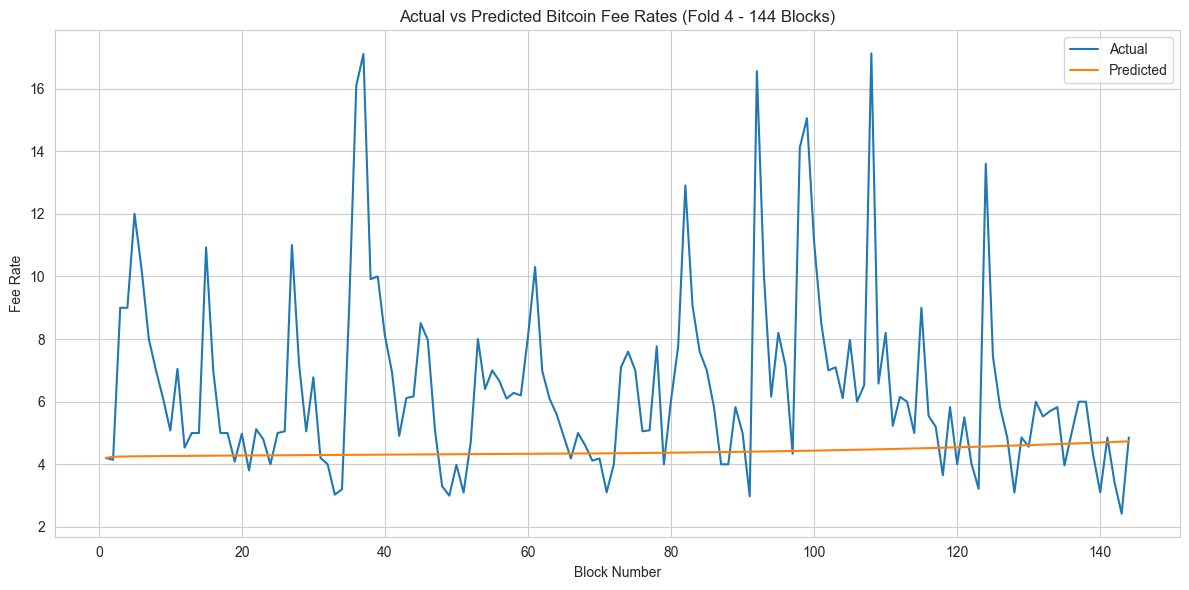

21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:21 - cmdstanpy - INFO - Chain [1] done processing


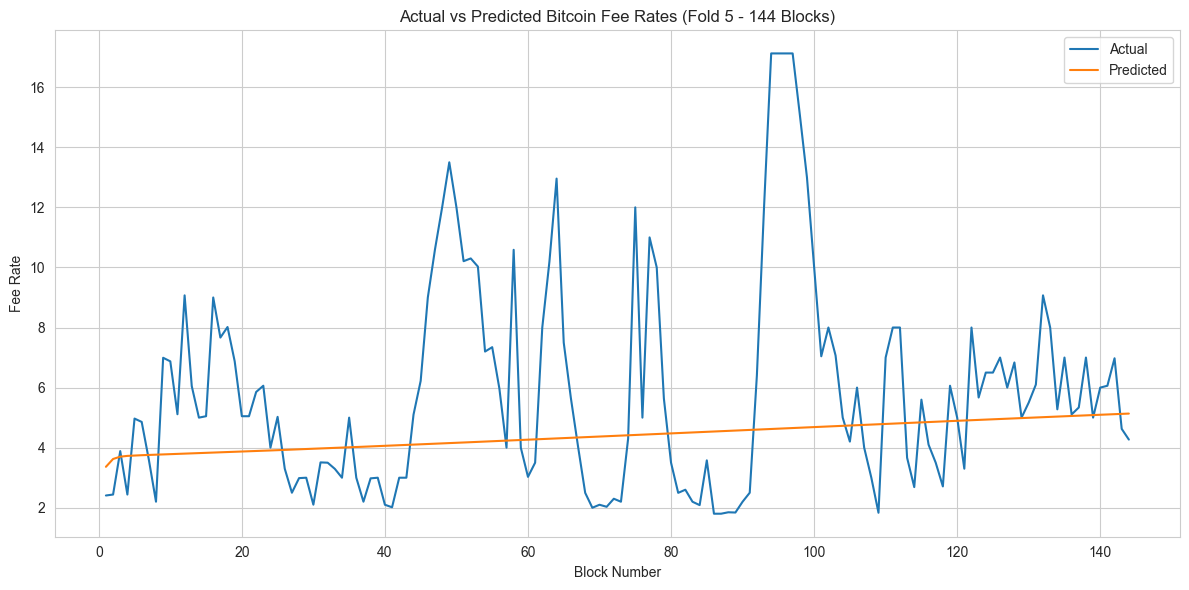


Cross-Validation Performance (Using Predicted Features):
Mean Absolute Error (CV): 3.6753
Root Mean Squared Error (CV): 4.5675
R-squared Score (CV): -0.6900
MAPE (CV): 40.2352%
Theil's U Statistic (CV): 0.6067
Directional Accuracy (CV): 36.3636%
Training and Prediction time: 23.85s


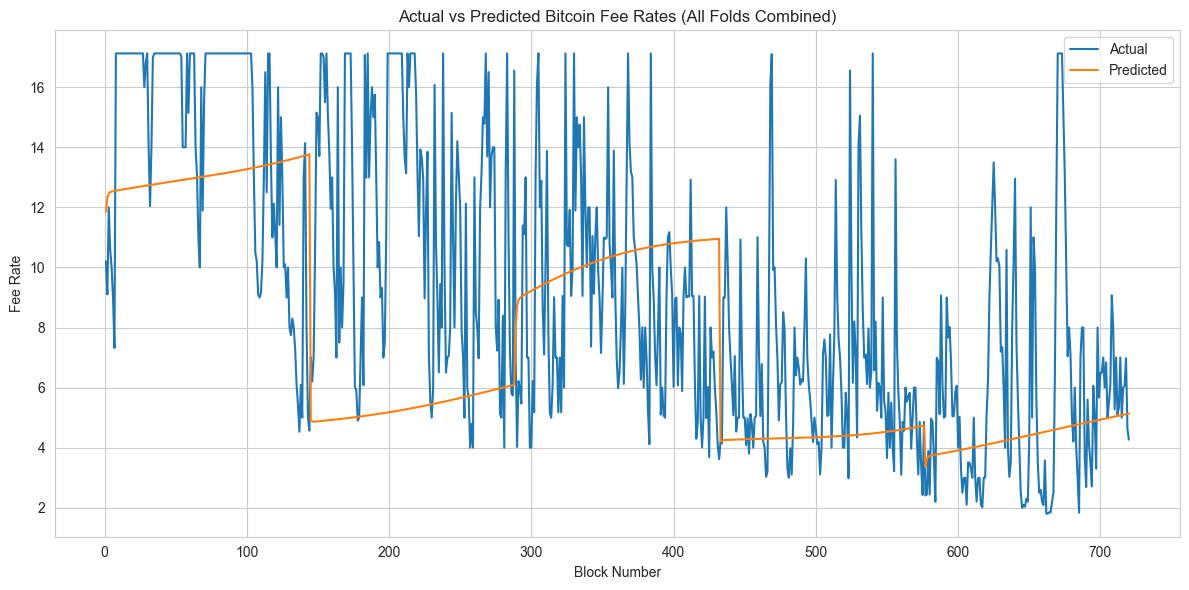

In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random

# Set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

# Call the function to set the seed
set_seed(42)
start = time.time()

# Load and preprocess data_history
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Prepare data_history for Prophet
prophet_df = df[['block_time', 'block_median_fee_rate']].rename(columns={'block_time': 'ds', 'block_median_fee_rate': 'y'})

# Add essential features
prophet_df['hour'] = prophet_df['ds'].dt.hour
prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
prophet_df['is_weekend'] = prophet_df['day_of_week'].isin([5, 6]).astype(int)
prophet_df['fee_lag_1'] = prophet_df['y'].shift(1)
prophet_df['tx_count'] = df['tx_count']
prophet_df['mempool_size_mb'] = df['mempool_size_mb']
prophet_df['hash_rate'] = df['hash_rate']
prophet_df['avg_fee_rate'] = df['avg_fee_rate']
prophet_df['bitcoin_price_usd'] = df['bitcoin_price_usd']
prophet_df['block_height'] = df['block_height']
prophet_df['max_fee_rate'] = df['max_fee_rate']
prophet_df['difficulty'] = df['difficulty']
prophet_df['block_weight'] = df['block_weight']
prophet_df['block_version'] = df['block_version']
prophet_df['mempool_usage'] = df['mempool_usage']

# Remove rows with NaN values (since lagged features are introduced)
prophet_df = prophet_df.dropna()

# Custom TimeSeriesSplit with 144 blocks as test set
test_size = 144
n_splits = 5  # can change the number of splits based on the data

# Initialize lists to store cross-validation results
cv_predictions = []
cv_actuals = []
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []
theil_u_scores = []
da_scores = []

# To store cumulative predictions and actuals for the whole test dataset across all folds
all_y_true = []
all_y_pred = []

# Regressors to add to the model
regressors = ['hour', 'day_of_week', 'is_weekend', 'fee_lag_1', 'tx_count', 'mempool_size_mb', 
              'hash_rate', 'avg_fee_rate', 'bitcoin_price_usd', 'block_height', 'max_fee_rate', 
               'difficulty','block_weight', 'block_version', 'mempool_usage']  #

# Custom TimeSeriesSplit loop
n_total = len(prophet_df)
for fold_idx in range(n_splits):
    train_end = n_total - (n_splits - fold_idx) * test_size
    test_start = train_end
    test_end = test_start + test_size

    # Train and test sets
    train_window = prophet_df.iloc[:train_end]
    test_window = prophet_df.iloc[test_start:test_end]

    # Create and fit Prophet model
    model = Prophet(
        changepoint_prior_scale=4.0,  # Increased to better capture abrupt changes
        seasonality_prior_scale=8,   # Regularization for seasonality
        holidays_prior_scale=6,
        daily_seasonality=False,      # Removed daily seasonality
        yearly_seasonality=False,
        seasonality_mode='additive'
    )

    # Add regressors to the model
    for regressor in regressors:
        model.add_regressor(regressor)

    # Fit the model on the training data_history
    model.fit(train_window)

    # Prepare for recursive prediction over the test set
    last_known_data = train_window.copy().iloc[-1]
    future_predictions = []

    # Predict for the next 144 blocks (test set)
    for i in range(test_size):  # Predict for 144 blocks only
        next_input = pd.DataFrame([last_known_data[['ds'] + regressors].fillna(0)])
        future = model.predict(next_input)
        yhat = future['yhat'].values[0]

        # Append the prediction
        future_predictions.append({'ds': last_known_data['ds'] + pd.Timedelta(minutes=10), 'y': yhat})

        # Update the features using the predicted value
        new_data = last_known_data.copy()
        new_data['ds'] = new_data['ds'] + pd.Timedelta(minutes=10)
        new_data['y'] = yhat
        new_data['fee_lag_1'] = yhat
        new_data['tx_count'] = last_known_data['tx_count']
        new_data['mempool_size_mb'] = last_known_data['mempool_size_mb']
        new_data['hash_rate'] = last_known_data['hash_rate']
        new_data['avg_fee_rate'] = last_known_data['avg_fee_rate']
        new_data['bitcoin_price_usd'] = last_known_data['bitcoin_price_usd']
        new_data['block_height'] = last_known_data['block_height']
        new_data['max_fee_rate'] = last_known_data['max_fee_rate']
        new_data['difficulty'] = last_known_data['difficulty']
        new_data['block_weight'] = last_known_data['block_weight']
        new_data['block_version'] = last_known_data['block_version']
        new_data['mempool_usage'] = last_known_data['mempool_usage']

        # Update last_known_data for next iteration
        last_known_data = new_data

    # Convert predictions to DataFrame
    future_predictions_df = pd.DataFrame(future_predictions)

    # Get actual values from the test window, limit to 144 blocks
    y_true = test_window['y'].values[:test_size]  # Only take the first 144 actual values
    y_pred = future_predictions_df['y'].values[:test_size]  # Only the first 144 predicted values

    # Append predictions and actuals to cumulative lists
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    # Plot actual vs predicted for the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true) + 1), y_true, label='Actual')
    plt.plot(range(1, len(y_pred) + 1), y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted Bitcoin Fee Rates (Fold {fold_idx + 1} - 144 Blocks)')
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate performance for this fold
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Additional performance metrics
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def directional_accuracy(y_true, y_pred):
        return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

    # def theil_u(y_true, y_pred):
    #     y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    #     y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
    #     numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    #     denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    #     return numerator / denominator
    
    
    def theil_u(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
    
        y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
        y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
    
        numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
        denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
        return numerator / denominator

    mape = mean_absolute_percentage_error(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred)
    theil_u_stat = theil_u(y_true, y_pred)

    # Append metrics to lists
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)
    theil_u_scores.append(theil_u_stat)
    da_scores.append(da)

# Compute the mean of all metrics
mae_cv = np.mean(mae_scores)
rmse_cv = np.mean(rmse_scores)
r2_cv = np.mean(r2_scores)
mape_cv = np.mean(mape_scores)
theil_u_cv = np.mean(theil_u_scores)
da_cv = np.mean(da_scores)

end = time.time()

# Print cross-validation results
print("\nCross-Validation Performance (Using Predicted Features):")
print(f"Mean Absolute Error (CV): {mae_cv:.4f}")
print(f"Root Mean Squared Error (CV): {rmse_cv:.4f}")
print(f"R-squared Score (CV): {r2_cv:.4f}")
print(f"MAPE (CV): {mape_cv:.4f}%")
print(f"Theil's U Statistic (CV): {theil_u_cv:.4f}")
print(f"Directional Accuracy (CV): {da_cv:.4f}%")
print(f"Training and Prediction time: {end-start:.2f}s")

# Plot the cumulative results for all folds
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(all_y_true) + 1), all_y_true, label='Actual')
plt.plot(range(1, len(all_y_pred) + 1), all_y_pred, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (All Folds Combined)')
plt.xlabel('Block Number')
plt.ylabel('Fee Rate')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define your features (regressors) and target
X = prophet_df[regressors]
y = prophet_df['y']

# Train a Random Forest Regressor to assess feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


                   importance
avg_fee_rate         0.728585
fee_lag_1            0.161821
tx_count             0.028692
block_height         0.013041
bitcoin_price_usd    0.011475
mempool_usage        0.008711
hash_rate            0.008199
mempool_size_mb      0.007921
max_fee_rate         0.007764
block_version        0.006624
hour                 0.006371
block_weight         0.005490
day_of_week          0.003696
difficulty           0.000848
is_weekend           0.000759


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the data_history for VIF calculation
X = prophet_df[regressors]  # Select the features for VIF analysis
X = X.dropna()  # Drop missing values

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


              Feature        VIF
0                hour   1.008679
1         day_of_week   1.015365
2          is_weekend   1.049978
3           fee_lag_1   1.138601
4            tx_count   1.166688
5     mempool_size_mb  30.771315
6           hash_rate   1.522484
7        avg_fee_rate   1.253205
8   bitcoin_price_usd   1.038491
9        block_height   0.008616
10       max_fee_rate   1.067754
11         difficulty   0.081865
12       block_weight   0.000016
13      block_version   0.988025
14      mempool_usage   1.007857


## Train the Model on the Entire Dataset to Predict the Next 144 Blocks and Compare with Actual Values


21:09:35 - cmdstanpy - INFO - Chain [1] start processing


Loading data...
Starting prediction process...

Training Prophet model on full dataset...


21:09:37 - cmdstanpy - INFO - Chain [1] done processing



Generating predictions for next 144 blocks...


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_50433/1181334702.py:115: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  prediction_times = pd.date_range(


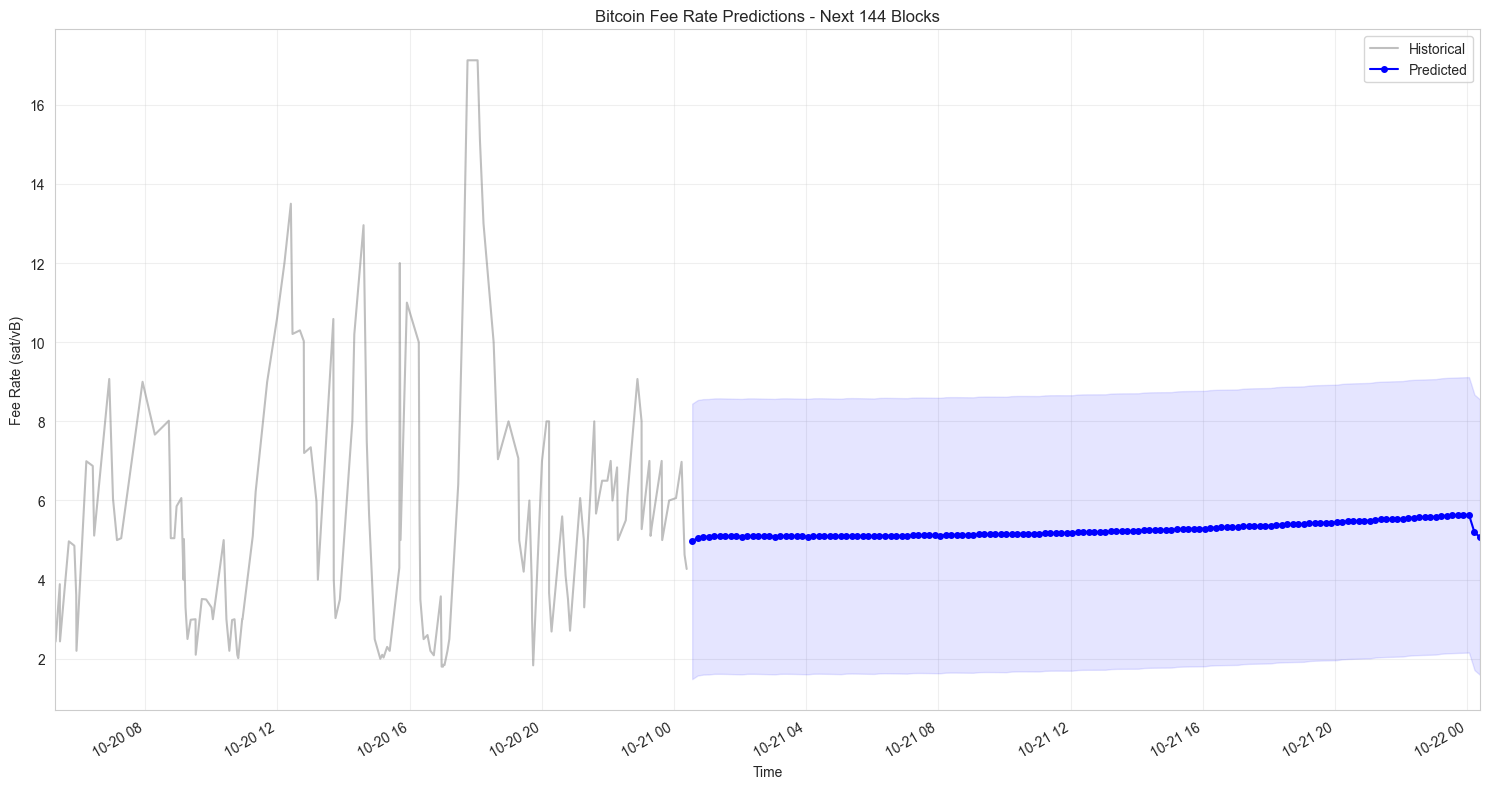


Prediction Statistics:
Mean predicted fee rate: 5.25 sat/vB
Min predicted fee rate: 4.97 sat/vB
Max predicted fee rate: 5.64 sat/vB

Predictions saved to 'prophet_future_fee_predictions.csv'

Prediction process completed in 4.98 seconds!


In [17]:


def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)

def predict_future_fees(df, prediction_blocks=144):
    """Train Prophet model on full dataset and predict future fee rates"""
    try:
        print("Starting prediction process...")
        
        # Reset index to get block_time as a column
        df = df.reset_index()
        
        # Prepare data for Prophet
        prophet_df = df[['block_time', 'block_median_fee_rate']].rename(
            columns={'block_time': 'ds', 'block_median_fee_rate': 'y'}
        )
        
        # Add features
        prophet_df['hour'] = prophet_df['ds'].dt.hour
        prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
        prophet_df['is_weekend'] = prophet_df['day_of_week'].isin([5, 6]).astype(int)
        prophet_df['fee_lag_1'] = prophet_df['y'].shift(1)
        prophet_df['tx_count'] = df['tx_count']
        prophet_df['mempool_size_mb'] = df['mempool_size_mb']
        prophet_df['hash_rate'] = df['hash_rate']
        prophet_df['avg_fee_rate'] = df['avg_fee_rate']
        prophet_df['bitcoin_price_usd'] = df['bitcoin_price_usd']
        prophet_df['block_height'] = df['block_height']
        prophet_df['max_fee_rate'] = df['max_fee_rate']
        prophet_df['difficulty'] = df['difficulty']
        prophet_df['block_weight'] = df['block_weight']
        prophet_df['block_version'] = df['block_version']
        prophet_df['mempool_usage'] = df['mempool_usage']
        
        # Remove rows with NaN values
        prophet_df = prophet_df.dropna()
        
        # Define regressors
        regressors = [
            'hour', 'day_of_week', 'is_weekend', 'fee_lag_1', 'tx_count',
            'mempool_size_mb', 'hash_rate', 'avg_fee_rate', 'bitcoin_price_usd',
            'block_height', 'max_fee_rate', 'difficulty', 'block_weight',
            'block_version', 'mempool_usage'
        ]
        
        print("\nTraining Prophet model on full dataset...")
        # Initialize and train Prophet model
        model = Prophet(
            changepoint_prior_scale=4.0,
            seasonality_prior_scale=8,
            holidays_prior_scale=6,
            daily_seasonality=False,
            yearly_seasonality=False,
            seasonality_mode='additive'
        )
        
        # Add regressors
        for regressor in regressors:
            model.add_regressor(regressor)
            
        # Fit model
        model.fit(prophet_df)
        
        print("\nGenerating predictions for next 144 blocks...")
        # Initialize prediction process
        last_known_data = prophet_df.iloc[-1]
        future_predictions = []
        
        # Generate predictions recursively
        for i in range(prediction_blocks):
            # Prepare next input
            next_input = pd.DataFrame([last_known_data[['ds'] + regressors].fillna(0)])
            future = model.predict(next_input)
            yhat = future['yhat'].values[0]
            
            # Store prediction
            future_predictions.append({
                'timestamp': last_known_data['ds'] + pd.Timedelta(minutes=10),
                'predicted_fee_rate': yhat
            })
            
            # Update features for next prediction
            new_data = last_known_data.copy()
            new_data['ds'] = new_data['ds'] + pd.Timedelta(minutes=10)
            new_data['y'] = yhat
            new_data['fee_lag_1'] = yhat
            
            # Maintain other features at their last known values
            for feat in regressors:
                if feat not in ['hour', 'day_of_week', 'is_weekend', 'fee_lag_1']:
                    new_data[feat] = last_known_data[feat]
                    
            # Update time-based features
            new_data['hour'] = new_data['ds'].hour
            new_data['day_of_week'] = new_data['ds'].dayofweek
            new_data['is_weekend'] = new_data['day_of_week'] in [5, 6]
            
            # Update last_known_data for next iteration
            last_known_data = new_data
        
        # Create results DataFrame
        results_df = pd.DataFrame(future_predictions)
        
        # Plot predictions with historical context
        plt.figure(figsize=(15, 8))
        
        # Get the last 144 blocks for historical context
        historical_data = df.iloc[-144:].copy()
        historical_times = historical_data['block_time']
        historical_values = historical_data['block_median_fee_rate']
        
        # Create proper timestamps for predictions
        last_time = historical_times.iloc[-1]
        prediction_times = pd.date_range(
            start=last_time,
            periods=prediction_blocks + 1,
            freq='10T'
        )[1:]  # Skip first entry as it overlaps with last historical point
        
        # Plot historical data
        plt.plot(historical_times, historical_values, 
                label='Historical', color='gray', alpha=0.5)
        
        # Plot predictions
        plt.plot(prediction_times, results_df['predicted_fee_rate'], 
                label='Predicted', color='blue', marker='o', markersize=4)
        
        plt.title('Bitcoin Fee Rate Predictions - Next 144 Blocks')
        plt.xlabel('Time')
        plt.ylabel('Fee Rate (sat/vB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Format x-axis
        plt.gcf().autofmt_xdate()  # Angle and align the tick labels so they look better
        
        # Add confidence bands
        std_dev = np.std(historical_values)
        plt.fill_between(
            prediction_times,
            results_df['predicted_fee_rate'] - std_dev,
            results_df['predicted_fee_rate'] + std_dev,
            color='blue', alpha=0.1, label='±1σ Confidence'
        )
        
        # Set x-axis limits to show only relevant timeframe
        plt.xlim(historical_times.iloc[0], prediction_times[-1])
        
        plt.tight_layout()
        plt.show()
        
        # Print prediction statistics
        print("\nPrediction Statistics:")
        print(f"Mean predicted fee rate: {results_df['predicted_fee_rate'].mean():.2f} sat/vB")
        print(f"Min predicted fee rate: {results_df['predicted_fee_rate'].min():.2f} sat/vB")
        print(f"Max predicted fee rate: {results_df['predicted_fee_rate'].max():.2f} sat/vB")
        
        # Save predictions to CSV with proper timestamps
        results_df['timestamp'] = prediction_times
        results_df.to_csv('prophet_future_fee_predictions.csv', index=False)
        print("\nPredictions saved to 'prophet_future_fee_predictions.csv'")
        
        return results_df
        
    except Exception as e:
        print(f"Error in prediction process: {str(e)}")
        raise

def main():
    try:
        # Load and preprocess data
        print("Loading data...")
        df = pd.read_csv('real_time_cleaned.csv')
        df['block_time'] = pd.to_datetime(df['block_time'])
        
        # Sort by block_time and set as index
        df = df.sort_values('block_time').set_index('block_time')
        
        # Generate predictions
        start_time = time.time()
        predictions_df = predict_future_fees(df, prediction_blocks=144)
        end_time = time.time()
        
        print(f"\nPrediction process completed in {end_time - start_time:.2f} seconds!")
        return predictions_df
        
    except Exception as e:
        print(f"Error in main process: {str(e)}")
        raise

if __name__ == "__main__":
    set_seed(42)  # Set random seed for reproducibility
    predictions_df = main()

Performance Metrics:
Mean Absolute Error (MAE): 3.0785
Root Mean Squared Error (RMSE): 4.2005
Theil's U Statistic: 0.6082


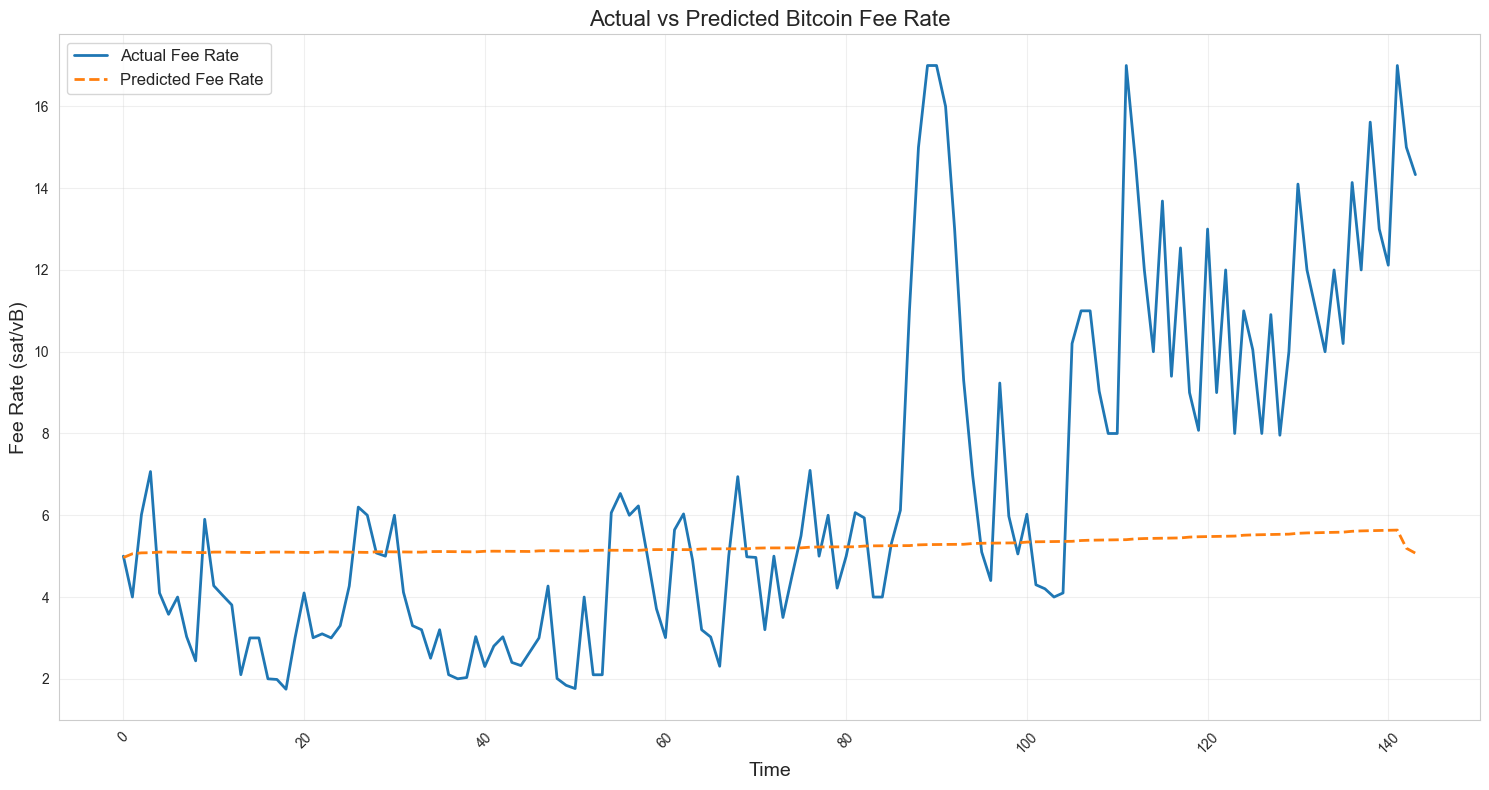

In [20]:
sf=pd.read_csv('test.csv')
actual_values = sf['block_median_fee_rate']
predicted_values = predictions_df['predicted_fee_rate']

# Calculate metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
theils_u = theil_u(actual_values, predicted_values)
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Theil's U Statistic: {theils_u:.4f}")

plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(actual_values.index, actual_values, label='Actual Fee Rate',  linewidth=2)

# Plot predicted values
plt.plot(actual_values.index, predicted_values, label='Predicted Fee Rate',linestyle='--', linewidth=2)

# Add title and labels
plt.title('Actual vs Predicted Bitcoin Fee Rate', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Fee Rate (sat/vB)', fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Add grid for better visualization
plt.grid(alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
